Author: Chris J. Dallmann \
Affiliation: University of Wuerzburg \
Last revision: 17-July-2025

In [25]:
import pandas as pd
pd.options.mode.chained_assignment = None
import numpy as np
import itertools
import matplotlib.pyplot as plt
import seaborn as sns
import cmocean

In [26]:
# Set parameters 
data_dir = r'Z:/Data/Roadrunner/'
syn_prediction = 'princeton' 
syn_thresh = 5

In [27]:
# Load connectivity 
if syn_prediction == 'princeton':
    df_connectivity = pd.read_csv(data_dir + 'flywire_v783_connections_princeton.csv')
    df_connectivity = df_connectivity.rename(columns={"pre_pt_root_id": "pre_root_id", "post_pt_root_id": "post_root_id"}, errors="raise")
else:
    df_connectivity = pd.read_csv(data_dir + 'flywire_v783_connections.csv')
    
# Load neuron classifications 
df_class = pd.read_csv(data_dir + 'flywire_v783_classifications.csv')

# Load neurotransmitter information 
df_nt = pd.read_csv(data_dir + 'flywire_v783_neurotransmitters.csv') # neuron.csv

# Load neurons of interest
df_neurons_of_interest = pd.read_csv(data_dir + 'neurons_of_interest.csv')

In [28]:
# Set source neurons

# Sorted based on manc_neuropil_analysis.ipynb
dict_ids = {}
dict_ids['DNg101'] = [720575940621246068, 720575940614089726]
dict_ids['DNg102'] = [720575940624877360, 720575940630480348]
dict_ids['DNpe020'] = [720575940623125628, 720575940624766700]
dict_ids['DNge103'] = [720575940614075363, 720575940630803727]
dict_ids['DNge050'] = [720575940611813842, 720575940647586948]
dict_ids['DNg44'] = [720575940628844712, 720575940614186449]
dict_ids['DNd05'] = [720575940629736720, 720575940631333195]
dict_ids['DNge048'] = [720575940617399257, 720575940609376707]
dict_ids['DNg45'] = [720575940622486644, 720575940627732423]
dict_ids['DNge082'] = [720575940628669545, 720575940626092302]
dict_ids['DNge150'] = [720575940625489160]
dict_ids['DNp68'] = [720575940617952034, 720575940615378700]
dict_ids['DNpe053'] = [720575940624402173, 720575940639242303]
dict_ids['DNp13'] = [720575940619486891, 720575940625295339]
dict_ids['DNp64'] = [720575940629846722, 720575940639789475]
dict_ids['DNp52'] = [720575940625513360, 720575940616886301]
dict_ids['DNpe042'] = [720575940615092019, 720575940619038493]
dict_ids['DNg55'] = [720575940622010373]
dict_ids['DNge053'] = [720575940630135084, 720575940638204132]

source_ids = list(itertools.chain(*list(dict_ids.values())))

In [29]:
# Sum synapses across neuropils
df_connectivity = df_connectivity.groupby(['pre_root_id','post_root_id'])['syn_count'].sum().reset_index().sort_values('syn_count', ascending=False)

In [30]:
# Remove connections between neurons smaller than syn_thresh 
df_connectivity = df_connectivity[df_connectivity.syn_count>=syn_thresh]

In [31]:
# Trim connectivity dataframe
df_connectivity_post = df_connectivity[df_connectivity.pre_root_id.isin(source_ids)]

In [32]:
# Add information about postsynaptic neurons 
super_class = []

for index, row in df_connectivity_post.iterrows():
    super_class.append(df_class.super_class[df_class.root_id==row.post_root_id].item())
    
df_connectivity_post['super_class'] = super_class

In [33]:
df_connectivity_post

,pre_root_id,post_root_id,syn_count,super_class
9390396,720575940624402173,720575940622160705,331,central
18108503,720575940639242303,720575940622160705,312,central
9390516,720575940624402173,720575940623432918,299,central
9389723,720575940624402173,720575940609592270,231,central
9391128,720575940624402173,720575940631299602,211,central
...,...,...,...,...
17765763,720575940638204132,720575940644122903,5,central
17765782,720575940638204132,720575940661289345,5,visual_centrifugal
17765773,720575940638204132,720575940646682676,5,central
17765766,720575940638204132,720575940644650531,5,central


## Compute connectivity with super classes

In [46]:
# Initialize synapse dictionary
super_classes = df_connectivity_post.super_class.unique().tolist() 
dict_synapses = {}
for source_id in source_ids:
    dict_synapses[source_id] = {}
    for super_class in super_classes:
        dict_synapses[source_id][super_class] = 0

In [47]:
# Populate synapse dictionary
for source_id in source_ids:
    # Use original df_connectivity to get total synapse count
    syn_count_total = df_connectivity.syn_count[df_connectivity.pre_root_id == source_id].sum().item()
    
    for super_class in super_classes:
        syn_count = df_connectivity_post.syn_count[(df_connectivity_post.pre_root_id == source_id) & (df_connectivity_post.super_class == super_class)].sum().item()
        dict_synapses[source_id][super_class] += syn_count / syn_count_total

In [48]:
# Build connectivity matrix
connectivity_matrix = np.zeros((len(source_ids),len(super_classes)))
for source_index, source_id in enumerate(dict_synapses.keys()):
    for super_class_index, super_class in enumerate(super_classes):
        connectivity_matrix[source_index,super_class_index] = dict_synapses[source_id][super_class]

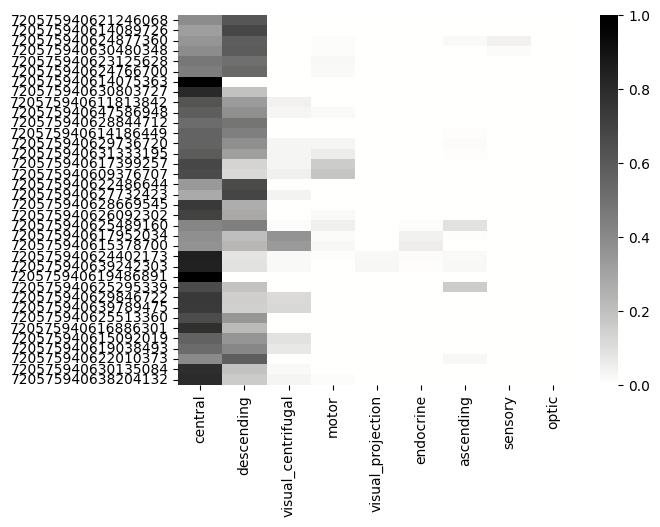

In [49]:
# Plot connectivity matrix
neuron_names = list(dict_ids.keys())

cmap = cmocean.cm.gray_r

sns.heatmap(connectivity_matrix,
            yticklabels = source_ids,
            xticklabels = super_classes,
            cmap = cmap,
            vmax = 1)
#plt.savefig(r"C:\Users\Chris\Desktop\figure.eps", bbox_inches="tight", transparent=True)
plt.show()

In [50]:
# Average rows for the same source neuron type
neuron_names = list(dict_ids.keys())
connectivity_matrix_grouped = np.zeros((len(neuron_names),np.size(connectivity_matrix,axis=1)))
for key_index, key in enumerate(neuron_names):
    n_neurons = len(dict_ids[key])   
    if key_index == 0:
        start_index = 0
    else:
        start_index = end_index 
    end_index = start_index + n_neurons
    
    connectivity_matrix_grouped[key_index,:] = np.mean(connectivity_matrix[start_index:end_index,],axis=0)

connectivity_matrix = connectivity_matrix_grouped
del connectivity_matrix_grouped

In [51]:
# Sort connectivity matrix 
neuron_names = list(dict_ids.keys())

# Sort rows based on ... ipynb
#sort_index = [5, 8, 1, 10, 4, 3, 9, 6,7, 11, 0, 2]
#connectivity_matrix = connectivity_matrix[[i for i in sort_index],:]
#neuron_names = [neuron_names[i] for i in sort_index]

# Sort columns
sort_list = ['central','descending','ascending','motor','visual_centrifugal','visual_projection','optic','endocrine']
sort_index = [super_classes.index(i) for i in sort_list]
connectivity_matrix = connectivity_matrix[:, [i for i in sort_index]]
super_classes = [super_classes[i] for i in sort_index]

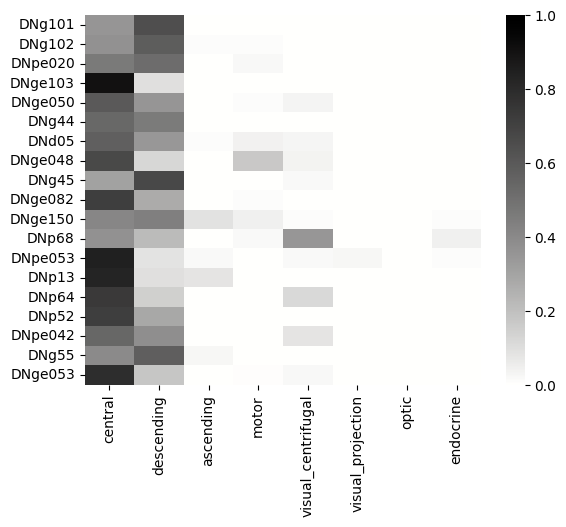

In [53]:
# Plot connectivity matrix
cmap = cmocean.cm.gray_r

sns.heatmap(connectivity_matrix,
            yticklabels = neuron_names,
            xticklabels = super_classes,
            cmap = cmap,
            vmax = 1)
#plt.savefig(r"C:\Users\Chris\Desktop\figure.eps", bbox_inches="tight", transparent=True)
plt.show()

In [45]:
#connectivity_matrix.sum(axis=1)

## Compute connectivity onto each other

In [42]:
# Build connectivity matrix
connectivity_matrix = np.zeros((len(source_ids),len(source_ids)))
for row_index, row_id in enumerate(dict_synapses.keys()):
    for col_index, col_id in enumerate(dict_synapses.keys()):
        syn_count = df_connectivity_post.syn_count[(df_connectivity_post.pre_root_id == row_id) & (df_connectivity_post.post_root_id == col_id)].sum().item()
        connectivity_matrix[row_index,col_index] += syn_count

In [43]:
# Average rows for the same source neuron type
neuron_names = list(dict_ids.keys())
connectivity_matrix_grouped = np.zeros((len(neuron_names),len(source_ids)))
for key_index, key in enumerate(neuron_names):
    n_neurons = len(dict_ids[key])   
    if key_index == 0:
        start_index = 0
    else:
        start_index = end_index 
    end_index = start_index + n_neurons
    
    connectivity_matrix_grouped[key_index,:] = np.mean(connectivity_matrix[start_index:end_index,],axis=0)

connectivity_matrix = connectivity_matrix_grouped
del connectivity_matrix_grouped

# Average columns for the same source neuron type
neuron_names = list(dict_ids.keys())
connectivity_matrix_grouped = np.zeros((len(neuron_names),len(neuron_names)))
for key_index, key in enumerate(neuron_names):
    n_neurons = len(dict_ids[key])   
    if key_index == 0:
        start_index = 0
    else:
        start_index = end_index 
    end_index = start_index + n_neurons
    
    connectivity_matrix_grouped[:,key_index] = np.mean(connectivity_matrix[:,start_index:end_index],axis=1)

connectivity_matrix = connectivity_matrix_grouped
del connectivity_matrix_grouped

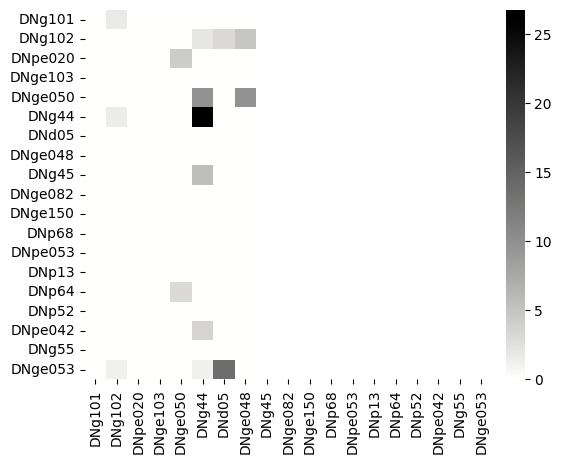

In [45]:
# Plot connectivity matrix
cmap = cmocean.cm.gray_r

sns.heatmap(connectivity_matrix,
            yticklabels = neuron_names,
            xticklabels = neuron_names,
            cmap = cmap
           )
#plt.savefig(r"C:\Users\Chris\Desktop\figure.eps", bbox_inches="tight", transparent=True)
plt.show()